<a href="https://colab.research.google.com/github/tjtyler/MachLearn_MultiLayerPerceptron_BackProp/blob/main/lab_2_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation Lab





In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def sigmoid(net):
  """The sigmoid function."""
  return 1.0/(1.0+np.exp(-net))

In [ ]:
lr = 0.1
input1 = np.array([-.4,.3,1])
first_set_wts = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0]])
second_set_wts = np.array([[0,0],[0,0],[0,0],[0,0],[0,0]])
nets_lay1 = np.matmul(input1,first_set_wts)
print('nets at hidden layer:\n',nets_lay1)
v_sigmoid = np.vectorize(sigmoid)
outputs_lay1 = v_sigmoid(nets_lay1)
print('outputs of hidden layer:\n',outputs_lay1)
outputs_lay1_with_bias = np.concatenate((outputs_lay1,np.array([1])))
print('outputs of hidden layer with bias', outputs_lay1_with_bias)
nets_outNodes = np.matmul(outputs_lay1_with_bias, second_set_wts)
print('nets at output nodes', nets_outNodes)
outputs_outNodes = v_sigmoid(nets_outNodes)
print('outputs at output nodes',outputs_outNodes)
target_vec = np.array([0,1])
error_at_output_nodes = (target_vec - outputs_outNodes)*outputs_outNodes*(1-outputs_outNodes)
print('errors at output nodes',error_at_output_nodes)
second_set_wts_no_bias = second_set_wts[:-1,:]
w_dot_delta = np.matmul(second_set_wts_no_bias,error_at_output_nodes)
errors_at_hidden_nodes = (outputs_lay1*(1-outputs_lay1)).reshape(outputs_lay1.shape[0],1)*(w_dot_delta.reshape(w_dot_delta.shape[0],1))
print('errors_at_hidden_nodes\n', errors_at_hidden_nodes)
delta_wts_second_set = lr*error_at_output_nodes*outputs_lay1_with_bias.reshape(outputs_lay1_with_bias.shape[0],1)
print('delta_wts_second_set\n',delta_wts_second_set)
print('lr', lr)
print('errors_at_hidden_nodes', errors_at_hidden_nodes)
print('input1', input1)
delta_wts_first_set = lr*input1.reshape(input1.shape[0],1)*errors_at_hidden_nodes.flatten()
print('delta_wts_first_set \n',delta_wts_first_set)
first_set_wts = first_set_wts + delta_wts_first_set
print('new first set of weights\n', first_set_wts)
second_set_wts = second_set_wts + delta_wts_second_set
print('new second set of weights\n', second_set_wts)


print('\n\nNEW TRAINING INSTANCE')
lr = 0.1
input1 = np.array([-.3,.8,1])
nets_lay1 = np.matmul(input1,first_set_wts)
print('nets at hidden layer:\n',nets_lay1)
v_sigmoid = np.vectorize(sigmoid)
outputs_lay1 = v_sigmoid(nets_lay1)
print('outputs of hidden layer:\n',outputs_lay1)
outputs_lay1_with_bias = np.concatenate((outputs_lay1,np.array([1])))
print('outputs of hidden layer with bias', outputs_lay1_with_bias)
nets_outNodes = np.matmul(outputs_lay1_with_bias, second_set_wts)
print('nets at output nodes', nets_outNodes)
outputs_outNodes = v_sigmoid(nets_outNodes)
print('outputs at output nodes',outputs_outNodes)
target_vec = np.array([0,1])
error_at_output_nodes = (target_vec - outputs_outNodes)*outputs_outNodes*(1-outputs_outNodes)
print('errors at output nodes',error_at_output_nodes)
second_set_wts_no_bias = second_set_wts[:-1,:]
w_dot_delta = np.matmul(second_set_wts_no_bias,error_at_output_nodes)
errors_at_hidden_nodes = (outputs_lay1*(1-outputs_lay1)).reshape(outputs_lay1.shape[0],1)*(w_dot_delta.reshape(w_dot_delta.shape[0],1))
print('errors_at_hidden_nodes\n', errors_at_hidden_nodes)
delta_wts_second_set = lr*error_at_output_nodes*outputs_lay1_with_bias.reshape(outputs_lay1_with_bias.shape[0],1)
print('delta_wts_second_set\n',delta_wts_second_set)
print('lr', lr)
print('errors_at_hidden_nodes', errors_at_hidden_nodes)
print('input1', input1)
delta_wts_first_set = lr*input1.reshape(input1.shape[0],1)*errors_at_hidden_nodes.flatten()
print('delta_wts_first_set \n',delta_wts_first_set)
first_set_wts = first_set_wts + delta_wts_first_set
print('new first set of weights\n', first_set_wts)
second_set_wts = second_set_wts + delta_wts_second_set
print('new second set of weights\n', second_set_wts)

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e., do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

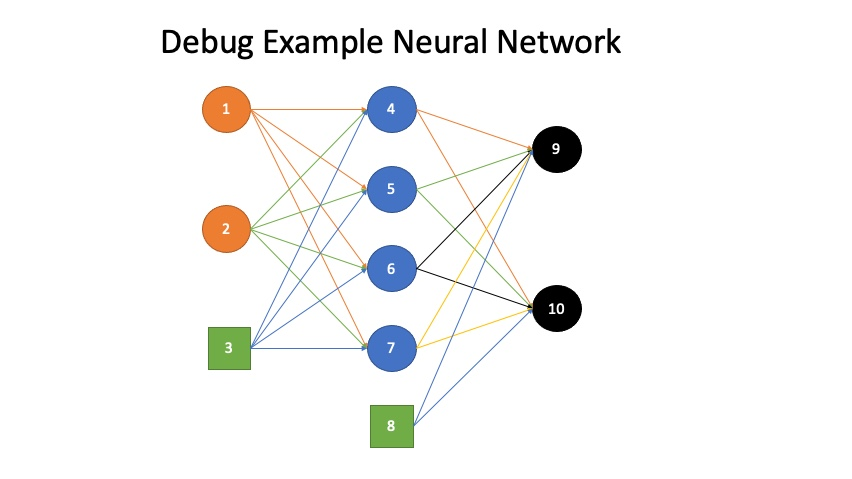

My weight matrix is set up like this: (for a network with 2 input nodes, 1 hidden layer with 4 nodes, and 2 output nodes), the first layer of weight would look like this:

$\begin{bmatrix} w_{14} & w_{15} & w_{16} & w_{17} \\ w_{24} & w_{25} & w_{26} & w_{27} \\ 
w_{34} & w_{35} & w_{36} & w_{37}\end{bmatrix}$

where $w_{14}$ means the weight from node 1 to node 4

The nets at the 4 hidden nodes are found by doing this: 

$\begin{bmatrix} x_{1} & x_{2} & b_{3} \end{bmatrix}$ $\begin{bmatrix} w_{14} & w_{15} & w_{16} & w_{17} \\ w_{24} & w_{25} & w_{26} & w_{27} \\ 
w_{34} & w_{35} & w_{36} & w_{37}\end{bmatrix}$

In [ ]:
def sigmoid(net):
  """The sigmoid function."""
  return 1.0/(1.0+np.exp(-net))

In [ ]:
def getSplit(arr,dec):
  """
  the 'arr' arguement should be the full numpy array before it is split into X and y
  """
  # THE NAMES OF THESE VARIABLES ARE AS IF THE SPLIT IS 80/20 BUT IT WORKS FOR ANY PERCENT BASED ON DEC (which is a decimal value)
  rand_start_index = random.randint(0,arr.shape[0]-1)
  num_vals_80 = round((arr.shape[0])*dec)
  num_vals_20 = arr.shape[0] - num_vals_80
  arr_80_combined = None
  arr_20 = None
  if (rand_start_index + num_vals_80) >= arr.shape[0]: # if the starting index (row) + the number of rows we need to make 80% of the rows >= the number of rows in arr
    num_vals_from_start = (rand_start_index + num_vals_80) - arr.shape[0] - 1 # the number of rows past the last row (back to the first row) that we need to make 80%
    arr_80_pt1 = arr[:num_vals_from_start,:] # part1 of the 80%_array from row[0] to row[num_vals_from_start - 1]
    arr_80_pt2 = arr[rand_start_index:,:] # part2 of the 80%_array from the rand_start_index (row) to the last index (row)
    arr_80_combined = np.concatenate((arr_80_pt1,arr_80_pt2), axis=0)
    arr_20 = arr[num_vals_from_start:rand_start_index,:] # 20%_array is everything in between
  else:
    arr_80_combined = arr[rand_start_index:num_vals_80,:]
    arr_20 = arr[num_vals_80:,:]
  return arr_80_combined, arr_20

In [ ]:
if self.cur_epoch == 0:
            if scoreMSE:
              last_score = self.score(self.X,self.y)
              self.accuracies.append(last_score)
              last_score = self.score_mse(X_validation,y_validation)
              self.MSEs.append(last_score)
            else:
              last_score = self.score(self.X,self.y)
              self.accuracies.append(last_score)
          else:
            cur_score = None
            cur_score_mse = None
            if scoreMSE:
              cur_score_mse = self.score_mse(X_validation, y_validation)
              cur_score = self.score(self.X,self.y)
            else:
              cur_score_mse = self.score_mse(X_validation,y_validation)
              cur_score = self.score(self.X,self.y)
            if ((cur_score - last_score)**2)**(1/2) < tol:
              num_epoch_no_change +=1
            else:
              num_epoch_no_change = 0
            last_score = cur_score
            last_score_mse = cur_score_mse
            if scoreMSE:
              self.MSEs.append(last_score_mse)
              self.accuracies.append(last_score)
            else:
              self.accuracies.append(last_score)

IndentationError: ignored

In [ ]:
from os import get_terminal_size
from typing_extensions import ParamSpecKwargs
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self, arch, epochs, lr=.1, momentum=0, shuffle=True,):
        """ Initialize class with chosen hyperparameters.

        Args:
            arch: a list of nodes at each layer, including the inputs and outputs, but not including bias nodes
            epochs: the number of epochs to run the fit function 
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.arch = arch # [2,2,1] means 2 inputs, 1 hidden layer with 2 nodes, and 1 output
        self.epochs = epochs
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.layer_wts =[] # list of numpy matrices or vectors with the first element being the weights between the inputs and the first hidden layer, the second element being the weights between the first and second hidden layers, etc.
        self.layer_prev_wts = None
        self.accuracies = []
        self.MSEs = []

                      # EXAMPLE 1 DEBUG
    def fit(self, X, y, epochs_no_change=11, tol=0.01, default_wts=False, initial_wts=0, scoreMSE=False, combined_array=None):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        self.X = X
        self.y = y

        X_validation = None
        y_validation = None

        v_sigmoid = np.vectorize(sigmoid) # this converts the sigmoid function to a function that that can take a vector and apply the function to it

        if default_wts:
          self.layer_wts = self.initialize_weights()
        else:
          self.layer_wts = self.initialize_weights_with_value(initial_wts)

        if scoreMSE:
          cutoff = combined_array.shape[1] - 1 #the index to split the X and y arrays
          np.random.shuffle(combined_array) # Shuffle

          training_data, validation_data = getSplit(combined_array,.85)

          self.X = training_data[:,:cutoff] #inputs: from 1st column to cutoff (exclusive)
          self.y = training_data[:,cutoff:] #targets: from cutoff to last column

          X_validation = validation_data[:,:cutoff]
          y_validation = validation_data[:,cutoff:]

        #--------------weight initialization working correctly------------------

        delta_wts = self.initialize_weights_with_value(0)
        self.layer_prev_wts = self.initialize_weights_with_value(0)
        self.cur_epoch = 0
        num_epoch_no_change = 0
        last_score = None
        last_mse = 0
        while self.cur_epoch < self.epochs and num_epoch_no_change < epochs_no_change:
          # print('\n\nEPOCH: ', self.cur_epoch)
          # if self.cur_epoch == 1:
            # print('self.layer_prev_wts \n',self.layer_prev_wts)

          X_bias = None # this will be the input matrix with a column of 1s concatenated for the bias
          if self.shuffle:
            self._shuffle_data(self.X, self.y)
            if scoreMSE:
              self._shuffle_data(X_validation,y_validation)
          bias = np.ones((self.X.shape[0],1)) # bias vector of ones
          X_bias = np.concatenate((self.X,bias), axis=1) # set X = X_shuffled with bias concatenated

          #---------------------------------------------------------------------
          # FOR EACH TRAINING INSTANCE
          for row in range(X_bias.shape[0]):
            # print('\nTRAINING INSTANCE:', row+1)
            Zs_by_layer = []
            nets_by_layer = []
            node_errors_by_layer = []
            
            # FORWARD-FEED
            for lay in range(0, len(self.layer_wts)):
              if lay == 0:
                net = np.matmul(X_bias[row], self.layer_wts[lay])
                nets_by_layer.append(net)
                Zs_lay = v_sigmoid(net)
                Zs_by_layer.append(Zs_lay)
              else:
                Zs_by_layer[lay-1] = np.insert(Zs_by_layer[lay-1],Zs_by_layer[lay-1].shape[0],[1]) # add a one to the Zs_by_layer for the bias
                net = np.matmul(Zs_by_layer[lay-1], self.layer_wts[lay])
                nets_by_layer.append(net)
                Zs_lay = v_sigmoid(net)
                Zs_by_layer.append(Zs_lay)
                
            # BACK PROPAGATE
            target_vec = self.get_target_vec(row,self.y)
            target_vec = target_vec.flatten()
            for lay_indx in reversed(range(0, len(self.layer_wts))): # there are (number_of_layers - 1) sets of wts
              i = 0 # need this to access the node_erros from previous layer to calculate next layer (working backwards)
              if lay_indx == (len(self.layer_wts) - 1): 
                # COMPUTE THE ERROR AT THE OUTPUT NODES
                  # (target_j - z_j)*z_j*(1 - z_j)
                OutNodes_error = (target_vec - Zs_by_layer[lay_indx])*Zs_by_layer[lay_indx]*(np.ones(Zs_by_layer[lay_indx].shape) - Zs_by_layer[lay_indx])
                # ADD THE ERROR AT OUTPUT NODES VECTOR TO node_errors_by_layer
                node_errors_by_layer.append(OutNodes_error)

              else:
                # CALCULATE CHANGE IN WEIGHTS BETWEEN FINAL HIDDEN LAYER AND OUTPUTS
                  # delta_wts_ij = learning_rate * error_at_node_j * z_i
                lr_vec_shape = node_errors_by_layer[i-1].shape
                lr_vec = np.full(lr_vec_shape, self.lr) 
                Zs = Zs_by_layer[lay_indx]
                Zs = Zs.reshape(Zs.shape[0],1) # make Zs a column vector
                errors_at_nodes = node_errors_by_layer[i-1]
                delta_wts[lay_indx+1] = Zs * lr_vec * errors_at_nodes + self.momentum*(self.layer_prev_wts[lay_indx+1])

                # COMPUTE THE ERROR AT HIDDEN LAYER NODES
                  # error_node_j = Sum(error_node_k * wt_j->k)*f_prime_net_j
                delta_dot_w = np.matmul(self.layer_wts[lay_indx+1],node_errors_by_layer[i-1])
                delta_dot_w = delta_dot_w[:-1] # exclude the bias node
                  # f_prime_net = z_j*(1 - z_j)
                f_prime_net = (Zs_by_layer[lay_indx]) * (np.ones( (Zs_by_layer[lay_indx].shape[0]) ) - Zs_by_layer[lay_indx]) 
                f_prime_net = f_prime_net[:-1] # exclude the bias node
                # ADD THE ERROR AT HIDDEN LAYER NODES VECTOR TO node_errors_by_layer
                node_errors_by_layer.append(np.multiply(delta_dot_w ,f_prime_net))

                if lay_indx == 0:
                  lr_vec_shape = node_errors_by_layer[-1].shape
                  lr_vec = np.full(lr_vec_shape, self.lr) 
                  inputs = X_bias[row]
                  inputs = inputs.reshape(inputs.shape[0],1) # make inputs a column vector
                  errors_at_nodes = node_errors_by_layer[-1]

                  delta_wts[lay_indx] = inputs * lr_vec * errors_at_nodes + self.momentum*self.layer_prev_wts[lay_indx]
              i += 1

            node_errors_by_layer.reverse()
            for i in range(len(self.layer_wts)):
              self.layer_wts[i] = self.layer_wts[i] + delta_wts[i]
          
            # print('NEW UPDATED WEIGHTS\n', self.layer_wts)
            self.layer_prev_wts = delta_wts.copy()
          #---------------

          if self.cur_epoch == 0:
            last_score = self.score(self.X,self.y)
            self.accuracies.append(last_score)
          elif self.cur_epoch > 0:
            cur_score = self.score(self.X,self.y)
            last_score = cur_score
            self.accuracies.append(last_score)

          if scoreMSE:
            MSE_instances = self.calc_mse(X_validation,y_validation)
            MSE = np.mean(MSE_instances)
            self.MSEs.append(MSE)
            if np.abs(last_mse - MSE) < tol:
              num_epoch_no_change +=1
            else:
              num_epoch_no_change = 0
            last_mse = MSE
          
          self.cur_epoch +=1
        # print('Final Weights:\n', self.layer_wts)
        return self

    def get_target_vec(self,row,y):
      # THIS RETURNS A COLUMN VECTOR
      target_value = int(y[row][0])
      target_vector = np.zeros(shape=(self.arch[-1],1))
      target_vector[target_value][0] = 1
      return target_vector
      

    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """       
        bias = np.ones((X.shape[0],1)) # bias vector of ones
        X_bias = np.concatenate((X,bias), axis=1) # set X = X_shuffled with bias concatenated
        predictions = np.zeros([X.shape[0],1])
        v_sigmoid = np.vectorize(sigmoid)

        for row in range(X_bias.shape[0]):
          Zs_by_layer = []
          # FORWARD-FEED
          for lay in range(0, len(self.layer_wts)):
            if lay == 0:
              net = np.matmul(X_bias[row], self.layer_wts[lay])
              Zs_lay = v_sigmoid(net)
              Zs_by_layer.append(Zs_lay)
            else:
              Zs_by_layer[lay-1] = np.insert(Zs_by_layer[lay-1],Zs_by_layer[lay-1].shape[0],[1]) # add a one to the Zs_by_layer for the bias
              net = np.matmul(Zs_by_layer[lay-1], self.layer_wts[lay])
              Zs_lay = v_sigmoid(net)
              Zs_by_layer.append(Zs_lay) 
          predictions[row][0] = int(np.argmax(Zs_by_layer[-1]))
        return predictions

    def calc_mse(self, X, y):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """       
        bias = np.ones((X.shape[0],1)) # bias vector of ones
        X_bias = np.concatenate((X,bias), axis=1) # set X = X_shuffled with bias concatenated
        MSEs = np.zeros([X.shape[0],1])
        v_sigmoid = np.vectorize(sigmoid)

        for row in range(X_bias.shape[0]):
          Zs_by_layer = []
          # FORWARD-FEED
          for lay in range(0, len(self.layer_wts)):
            if lay == 0:
              net = np.matmul(X_bias[row], self.layer_wts[lay])
              Zs_lay = v_sigmoid(net)
              Zs_by_layer.append(Zs_lay)
            else:
              Zs_by_layer[lay-1] = np.insert(Zs_by_layer[lay-1],Zs_by_layer[lay-1].shape[0],[1]) # add a one to the Zs_by_layer for the bias
              net = np.matmul(Zs_by_layer[lay-1], self.layer_wts[lay])
              Zs_lay = v_sigmoid(net)
              Zs_by_layer.append(Zs_lay) 
          # print('Debug square\n', np.square(self.get_target_vec(y[row][0],y) - Zs_by_layer[-1].reshape(Zs_by_layer[-1].shape[0],1)))
          # print('target\n', self.get_target_vec(y[row][0],y))
          # print('output\n', Zs_by_layer[-1].reshape(Zs_by_layer[-1].shape[0],1))
          # print('mean\n', np.mean(np.square(self.get_target_vec(y[row][0],y) - Zs_by_layer[-1].reshape(Zs_by_layer[-1].shape[0],1))), '\n')
          MSEs[row][0] = np.mean(np.square(self.get_target_vec(y[row][0],y) - Zs_by_layer[-1].reshape(Zs_by_layer[-1].shape[0],1)))
        return MSEs

    def initialize_weights_with_value(self, val):
      # if self.arch = [2,3,2] then the lay1_wts have a shape of (3,3) and lay2_wts a shape of (4,2)
        wts_list = []
        for i in range(0, len(self.arch) - 1):
          wts_list.append(np.full((self.arch[i] + 1, self.arch[i+1]),val))
        return wts_list

    def initialize_weights(self):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        # if self.arch = [2,3,2] then the lay1_wts have a shape of (3,3) and lay2_wts a shape of (4,2)
        for i in range(0, len(self.arch) - 1):
          self.layer_wts.append(np.random.randn(self.arch[i] + 1, self.arch[i+1]))
        return self.layer_wts

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        self._shuffle_data(X,y)
        predictions = self.predict(X)
        correct = 0
        total = y.shape[0]
        for i in range(0, y.shape[0]):
          if predictions[i][0] == y[i][0]:
            correct += 1
        return correct/total

    def score_mse(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                mse accuracy of self.predict(X) wrt. y.
        """
        # self._shuffle_data(X,y)
        predictions = self.calc_mse(X,y)
        total = y.shape[0]
        sum = 0
        for i in range(0, y.shape[0]):
          sum += predictions[i][0]
        return sum/total
      

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        single_arr = np.concatenate((X,y), axis=1) # concatenate X and y into a single array
        np.random.shuffle(single_arr) # shuffle the rows of the concatenated X-y array
        cutoff = single_arr.shape[1] - 1 # the point to split the X and y arrays after shuffling
        X = single_arr[:,:cutoff] # the shuffled X array
        y = single_arr[:,cutoff:] # the shuffled y array
        return X,y

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.layer_wts

    def get_num_epochs(self):
      return self.cur_epoch
    
    def get_accuracies(self):
      return self.accuracies

    def get_MSEs(self):
      return self.MSEs


In [ ]:
# EXAMPLE 1 (CANVAS https://byu.instructure.com/courses/14142/pages/backprop-examples)
wts_layer1 = np.array([[.1,-.2],[.2,.3],[-.1,-.3]])
wts_layer2 = np.array([[.1,.2],[-.2,-.1],[-.3,.3]])
wts_layer3 = np.array([[.2,.1],[-.1,-.2],[.3,-.3]])

wts = [wts_layer1, wts_layer2, wts_layer3]

X = np.array([[0.3, 0.7]])
y_2D = np.array([[.1,1.0]])

mlp = MLP(arch=[2,2,2,2],epochs=1,lr=0.1,momentum=0,shuffle=False)
mlp.fit(X=X,y=y_2D,wts=wts,epochs_no_change=11,tol=0.01,default_wts=False,initial_wts=0)

## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://byu.instructure.com/courses/14142/files?preview=4421290)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://byu.instructure.com/courses/14142/files?preview=4537323) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://byu.instructure.com/courses/14142/files?preview=4537340) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [ ]:
from scipy.io.arff import loadarff 
import pandas as pd

# Load debug data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab2_backpropagation/data/linsep2nonorigin.arff')
df_data = pd.DataFrame(raw_data[0])
df_data['class'] = df_data['class'].astype(int) 

np_arr = df_data.to_numpy() #cast dataframe to numpy array
cutoff = np_arr.shape[1] - 1 #the index to split the X and y arrays

X = np_arr[:,:cutoff] #inputs: from 1st column to cutoff (exclusive)
y_2D = np_arr[:,cutoff:] #targets: from cutoff to last column

# Train on debug data
mlp = MLP(arch=[2,4,2],epochs=10,lr=0.1,momentum=0.5,shuffle=False)
mlp.fit(X=X,y=y_2D,epochs_no_change=11,tol=0.01,default_wts=False,initial_wts=0)

# Print weights
print('weights:\n',mlp.get_weights())
print('Accuracy = ', mlp.score(X,y_2D))

self.cur_epoch  10
weights:
 [array([[-0.00018149, -0.00018149, -0.00018149, -0.00018149],
       [ 0.00157468,  0.00157468,  0.00157468,  0.00157468],
       [-0.00788218, -0.00788218, -0.00788218, -0.00788218]]), array([[ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.02148778, -0.02148778]])]
Accuracy =  0.5


### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://byu.instructure.com/courses/14142/files?preview=4421294)

In [ ]:
# Load evaluation data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab2_backpropagation/data/data_banknote_authentication.arff')
df_data = pd.DataFrame(raw_data[0])

df_data['class'] = df_data['class'].astype(int) 
np_arr = df_data.to_numpy() #cast dataframe to numpy array
cutoff = np_arr.shape[1] - 1 #the index to split the X and y arrays

X = np_arr[:,:cutoff] #inputs: from 1st column to cutoff (exclusive)
y_2D = np_arr[:,cutoff:] #targets: from cutoff to last column

# Train on evaluation data
mlp = MLP(arch=[4,4,2],epochs=10,lr=0.1,momentum=0.5,shuffle=False)
mlp.fit(X=X,y=y_2D,epochs_no_change=11,tol=0.01,default_wts=False,initial_wts=0)
# Print weights
print('weights:\n',mlp.get_weights())
print('Accuracy = ', mlp.score(X,y_2D))

self.cur_epoch  10
weights:
 [array([[ 1.63828721,  1.63828721,  1.63828721,  1.63828721],
       [ 1.09612249,  1.09612249,  1.09612249,  1.09612249],
       [ 1.23447594,  1.23447594,  1.23447594,  1.23447594],
       [ 0.39269487,  0.39269487,  0.39269487,  0.39269487],
       [-2.09316151, -2.09316151, -2.09316151, -2.09316151]]), array([[ 1.81695611, -1.81695611],
       [ 1.81695611, -1.81695611],
       [ 1.81695611, -1.81695611],
       [ 1.81695611, -1.81695611],
       [-4.17098071,  4.17098071]])]
Accuracy =  0.9825072886297376


## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

Accuracy =  0.8709677419354839


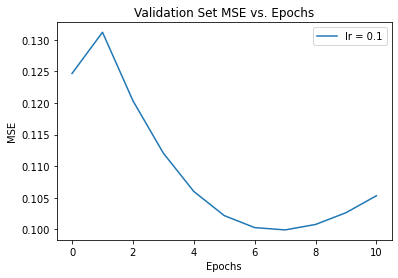

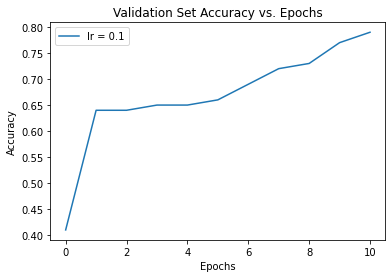

In [156]:
# Iris Classification
# Load evaluation data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab2_backpropagation/data/iris.arff')
df_data = pd.DataFrame(raw_data[0])

np_arr = df_data.to_numpy() #cast dataframe to numpy array
np_arr[np_arr == b'Iris-setosa'] = 0 
np_arr[np_arr == b'Iris-versicolor'] = 1 
np_arr[np_arr == b'Iris-virginica'] = 2 

training_data_OG, test_data = getSplit(np_arr, .8)

cutoff = np_arr.shape[1] - 1 #the index to split the X and y arrays

X = training_data_OG[:,:cutoff]
y_2D = training_data_OG[:,cutoff:]

X_testing = test_data[:,:cutoff]
y_testing = test_data[:,cutoff:]

# Train on evaluation data
mlp = MLP(arch=[4,8,3],epochs=50,lr=0.1,momentum=0.5,shuffle=True)
mlp.fit(X=X,y=y_2D,epochs_no_change=8,tol=0.01,default_wts=True,scoreMSE=True,combined_array=training_data_OG)
# Print weights
print('Accuracy = ', mlp.score(X_testing,y_testing))


xAxis = list(range(0,len(mlp.get_MSEs())))
yAxis = mlp.get_MSEs()
plt.plot(xAxis,yAxis,label='lr = 0.1')
plt.title('Validation Set MSE vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

xAxis = list(range(0,len(mlp.get_accuracies())))
yAxis = mlp.get_accuracies()
plt.plot(xAxis,yAxis,label='lr = 0.1')
plt.title('Validation Set Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://byu.instructure.com/courses/14142/files?preview=4537354)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

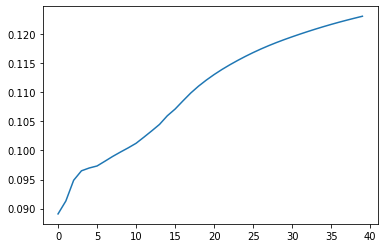

In [180]:
# Train on each dataset
# Load evaluation data
raw_data = loadarff('/content/drive/MyDrive/School/CS_472_MachLearning/labs/lab2_backpropagation/data/vowel.arff')
df_data = pd.DataFrame(raw_data[0])

np_arr = df_data.to_numpy() #cast dataframe to numpy array
np_arr[np_arr == b'hid'] = 0 
np_arr[np_arr == b'hId'] = 1 
np_arr[np_arr == b'hEd'] = 2 
np_arr[np_arr == b'hAd'] = 3 
np_arr[np_arr == b'hYd'] = 4 
np_arr[np_arr == b'had'] = 5 
np_arr[np_arr == b'hOd'] = 6 
np_arr[np_arr == b'hod'] = 7 
np_arr[np_arr == b'hUd'] = 8 
np_arr[np_arr == b'hud'] = 9 
np_arr[np_arr == b'hed'] = 10

np_arr = np_arr[:,3:] #remove the first three columns

training_data_OG, test_data = getSplit(np_arr, .8)

cutoff = np_arr.shape[1] - 1 #the index to split the X and y arrays

X = training_data_OG[:,:cutoff]
y_2D = training_data_OG[:,cutoff:]

X_testing = test_data[:,:cutoff]
y_testing = test_data[:,cutoff:]

# Train on evaluation data
mlp = MLP(arch=[10,20,11],epochs=150,lr=0.1,momentum=0.5,shuffle=True)
mlp.fit(X=X,y=y_2D,epochs_no_change=20,tol=0.001,default_wts=True,scoreMSE=True,combined_array=training_data_OG)


xAxis = list(range(0,len(mlp.get_MSEs())))
yAxis = mlp.get_MSEs()
plt.plot(xAxis,yAxis,label='lr = 0.1')

Accuracy =  0.457286432160804
MSE =  0.097102886407326


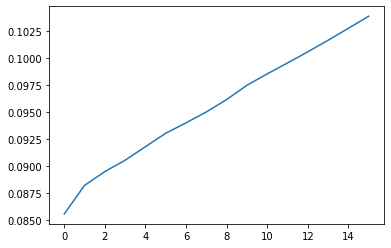

In [174]:
mlp = MLP(arch=[10,20,11],epochs=70,lr=0.05,momentum=0.5,shuffle=True)
mlp.fit(X=X,y=y_2D,epochs_no_change=15,tol=0.01,default_wts=True,scoreMSE=True,combined_array=training_data_OG)

print('Accuracy = ', mlp.score(X_testing,y_testing))
print('MSE = ', mlp.score_mse(X_testing, y_testing))

xAxis = list(range(0,len(mlp.get_MSEs())))
yAxis = mlp.get_MSEs()
plt.plot(xAxis,yAxis,label='lr = 0.05')


In [ ]:

plt.title('Validation Set MSE vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



*Discuss Intuition here*



## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

*Discuss Hidden Layer Nodes here*



## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy. 
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

*Discuss Momentum here*



## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [ ]:
# Load sklearn perceptron

# Train on voting dataset

*Record impressions*

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [ ]:
# Load sklearn perceptron

# Train on voting dataset

## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


*Discuss findings here*